# Work Flow

1. x_train: \[text1, text2, ...\]
   y_train: \[label1, label2, ...\]

2. Use x_train to generate vocabulary set (6432,) and get token_to_id map. This map will map a word to an index in vocabulary space. Transform text to \[index1, index2, ..., \]. 

    Unknown word is UNK, padding to fixed length vector using PAD.
    
3. Feed into Embedding layer -> LSTM -> Dense Layer

The accuracy is 0.986.

In [1]:
%load_ext autoreload

In [2]:
%autoreload

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
from src.data_preprocess.preprocess import DataProcessor
data_preprocessor = DataProcessor()
train_documents, test_documents = data_preprocessor.get_train_and_test_documents()

========== Extract data from pickle files ==========


In [5]:
from nltk.tokenize import word_tokenize
x_train = []
y_train = []
x_test = []
y_test = []
bag_of_classes = set()

for document in train_documents:
    bag_of_classes.add(document.class_list[0])
    x_train.append(' '.join(word_tokenize(document.text)))
    y_train.append({'label': document.class_list[0]})
        
for document in test_documents:
    for class_ in document.class_list:
        if class_ in bag_of_classes:
            x_test.append(' '.join(word_tokenize(document.text)))
            y_test.append({'label': class_})
            break

len(x_train), len(y_train), len(x_test), len(y_test)

(7310, 7310, 3347, 3347)

In [6]:
from collections import Counter
token_counts = Counter()
for text in x_train:
    token_counts.update(text.split())

In [7]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 42000
('the', 47506)
(',', 45806)
('.', 32917)
('of', 25521)
('to', 25291)
...
('a.h.a', 1)
('brampton', 1)
('1,916,000', 1)


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 0, 'Word counts')

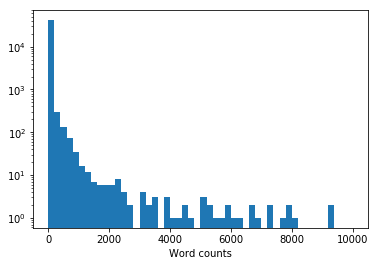

In [9]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts")

In [40]:
import gensim.downloader as api

# model = api.load('glove-twitter-100')

min_count = 10

# tokens = []
# for token, count in token_counts.items():
#     if count >= min_count and token in model.vocab:
#         tokens.append(token)

tokens = [token for token, count in token_counts.items() if count >= min_count]

In [41]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

Vocabulary size: 6432


In [42]:
token_to_id = {token: i for i, token in enumerate(tokens)}

In [43]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding """
    
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
        
    return matrix

In [44]:
print("Lines:")
print('\n'.join(x_train[::3000]), end='\n\n')
print("Matrix:")
print(as_matrix(x_train[::3000]))

Lines:
& # 2 ; u.s. economic data key to debt futures outlook by brad schade , reuters chicago , march 11 - u.s. economic data this week could be the key in determining whether u.s. interest rate futures break out of a 3-1/2 month trading range , financial analysts said . although market expectations are for february u.s. retail sales thursday and industrial production friday to show healthy gains , figures within or slightly below expectations would be positive for the market , the analysts said . `` you have to be impressed with the resiliency of bonds right now , '' said smith barney harris upham analyst craig sloane . treasury bond futures came under pressure today which traders linked to a persistently firm federal funds rate and a rise in oil prices . however , when sufficient selling interest to break below chart support in the june contract failed to materialize , participants who had sold bond futures early quickly covered short positions , they said . `` everyone is expecting

In [45]:
from sklearn.feature_extraction import DictVectorizer

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(y_train)

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

In [46]:
y_train_vector = categorical_vectorizer.transform(y_train)
y_test_vector = categorical_vectorizer.transform(y_test)
y_train_vector[::300], y_test_vector.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32), (3347, 73))

In [47]:
def make_batch(x, y, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    """
    
    batch = {}
    batch['Text'] = as_matrix(x, max_len)
    batch['Label'] = y
    
    if word_dropout != 0:
        batch["Text"] = apply_word_dropout(batch["Text"], 1. - word_dropout)
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [48]:
from sklearn.model_selection import train_test_split

data_train_X, val_x, data_train_y, val_y = train_test_split(as_matrix(x_train, None), y_train_vector, test_size=0.2, random_state=65)

data_test_X = as_matrix(x_test, None)
data_test_y = y_test_vector

In [49]:
len(val_x), len(val_y), len(data_train_y)

(1462, 1462, 5848)

In [50]:
import keras
import keras.layers as L
from keras.models import Sequential

In [51]:
model = Sequential()
model.add(L.Embedding(len(tokens), 128))
model.add(L.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(L.Dense(y_train_vector.shape[1], activation='sigmoid'))

In [52]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
batch_size = 256
epochs = 10

model.fit(data_train_X, 
          data_train_y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_x, val_y))

Train on 5848 samples, validate on 1462 samples
Epoch 1/10
5848/5848 [==============================] - 296s 51ms/step - loss: 0.4389 - acc: 0.8905 - val_loss: 0.1120 - val_acc: 0.9863
Epoch 2/10
 256/5848 [>.............................] - ETA: 3:55 - loss: 0.1126 - acc: 0.9863

KeyboardInterrupt: 

In [54]:
score, acc = model.evaluate(data_test_X, data_test_y, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

3347/3347 [==============================] - 64s 19ms/step
Test score: 0.09097513968299174
Test accuracy: 0.9863013621761366
